# 20140313 Assignment10

In [0]:
from google.colab import drive
import numpy as np
import cupy as cp
import random
import matplotlib.pyplot as plt

In [28]:
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0. **Opitimzation**

In [0]:
file_data   = "/content/drive/My Drive/Colab Notebooks/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

    
#
# example of distance function between two vectors x and y
#

def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

def sigmoid(x):
    s = 1 + np.exp(-x)
    return cp.reciprocal(s)

def gradientDescent(label, rate, layers, results, a, p, c):
    s = a[3][:-1] - label
    
    for i in reversed(range(len(layers))):
        dx = s @ a[i].transpose() / label.shape[1] 
        if not results[i].sum():
            results[i] = results[i] + dx**2 
        else:
            results[i] = p * results[i] + (1 - p) * dx**2
        layers[i] = layers[i] - rate * dx / (cp.sqrt(results[i] + c)) 
        
        if i != 0:
            s = (layers[i].transpose() @ s * (a[i]*(1-a[i])))[:-1]
    
def objectiveFunction(h, label):
    j = -((label*cp.log(h) + (1-label)*cp.log(1-h)).sum(axis=0)).mean()
    return j

def run(data, layers):
    h = [cp.vstack((data, cp.ones((1, data.shape[1]))))]
    
    for l in layers:
        s = sigmoid(l @ h[-1])
        h1 = cp.vstack((s, cp.ones((1, s.shape[1]))))
        h.append(h1)
        
    return h[-1][:-1], h

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_labels  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_labels[count]       = label
    list_image[:, count]    = im_vector

    count += 1

list_label = cp.zeros((10, num_image))

for i in range(num_image):
    list_label[list_labels[i]][i] = 1

#set 3 layers by designated dimensions
layers = [cp.random.normal(0, 1, (285, 785)),
         cp.random.normal(0, 1, (145,286)),
         cp.random.normal(0, 1, (10, 146))]

out = [cp.zeros((285, 785)),
      cp.zeros((145,286)),
      cp.zeros((10,146))]

#train size 0~999
train_image = list_image[:, :1000]
train_label = list_label[:, :1000]
train_accuracy = []

#test size ~9999
test_image = list_image[:, 1000:]
test_label = list_label[:, 1000:]
test_accuracy = []

learn_rate = 0.07
p = 0.65

mini = 0.000000000001

In [0]:
train_h, a = run(train_image, layers)

#1st values of training
train_acc1 = (train_h.argmax(axis=0) == train_label.argmax(axis=0)).mean()
train_e1 = objectiveFunction(train_h, train_label)

train_es = []
train_acs = []

In [0]:
test_h = run(test_image, layers)[0]

#initial values of test
test_acc1 = (test_h.argmax(axis=0) == test_label.argmax(axis=0)).mean()
test_e1 = objectiveFunction(test_h, test_label)

test_es = []
test_acs = []

In [0]:
for i in range(10000):
    train_es.append(train_e1)
    train_acs.append(train_acc1)
    
    test_es.append(test_e1)
    test_acs.append(test_acc1)
    
    gradientDescent(train_label, learn_rate, layers, out, a, p, mini)
    
    train_h, a = run(train_image, layers)
    
    #this iter values of training
    train_acc1 = (train_h.argmax(axis=0) == train_label.argmax(axis=0)).mean()
    train_e1 = objectiveFunction(train_h, train_label)
    
    test_h = run(test_image, layers)[0]
    
    #this iter values of test
    test_acc1 = (test_h.argmax(axis=0) == test_label.argmax(axis=0)).mean()
    test_e1 = objectiveFunction(test_h, test_label)

**1. Plot the Loss Curve**

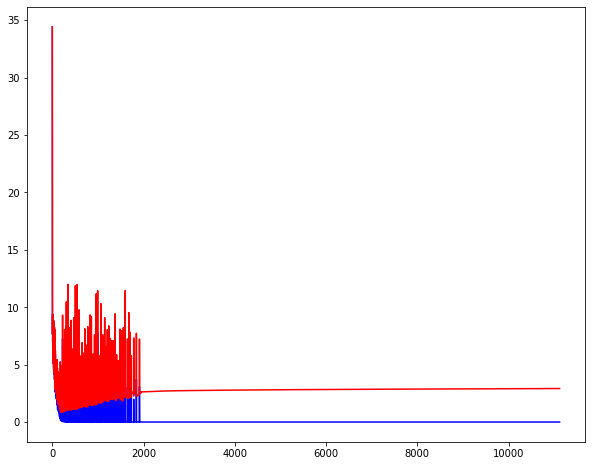

In [79]:
plt.figure(figsize = (10, 8))
plt.plot(train_es, color= 'blue', label = 'train')
plt.plot(test_es, color = 'red', label = 'test')
plt.show()

**2. Plot the Accuracy Curve**

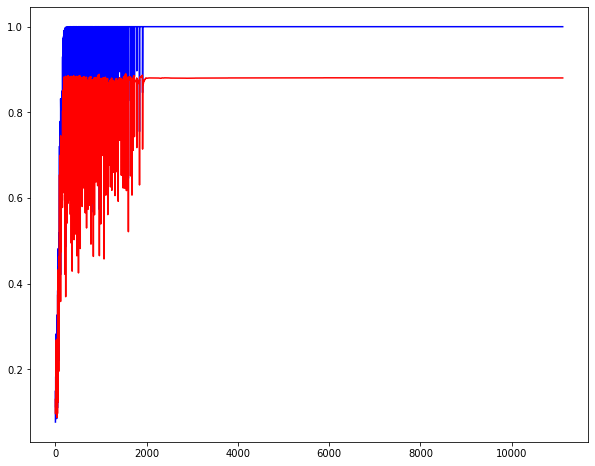

In [80]:
plt.figure(figsize = (10, 8))
plt.plot(train_acs, color = 'blue', label = 'train')
plt.plot(test_acs, color = 'red', label = 'test')
plt.show()

 **3. Plot Accuracy**

In [81]:
print(f'train accuracy: {train_acs[-1]*100}%:')
print(f'test accuracy: {test_acs[-1]*100}%:')

train accuracy: 100.0%:
test accuracy: 88.03333333333333%:


**4. Classification Example**

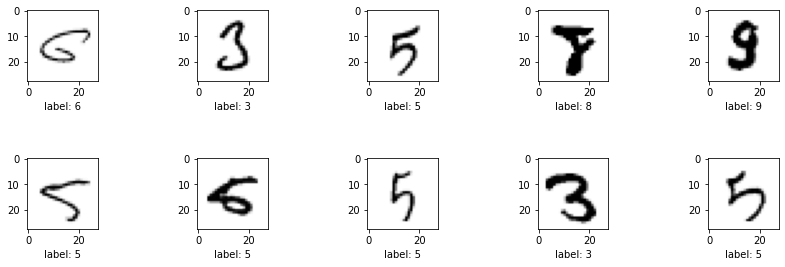

In [82]:
cnum = 0
new = run(test_image, layers)[0].transpose()
orig = test_label.transpose().argmax(axis = 1)
plt.figure(figsize = (15, 5))
#print(len(new))

for idx in range(len(new)):
    if (new[idx].argmax()+1).tolist() != orig[idx]:
        continue
    if cnum == 10:
        break
    plt.subplot(2, 10, 2*cnum + 1)
    image = test_image.transpose()[idx].reshape((28, 28))
    
    plt.imshow(image,cmap = 'Greys')
    plt.xlabel("label: {}" .format(orig[idx]))
    cnum += 1
    
plt.show()

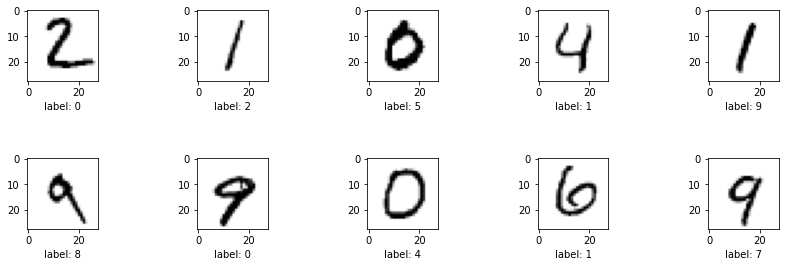

In [83]:
cnum = 0
new = run(test_image, layers)[0].transpose()
orig = list_labels[6000:]
plt.figure(figsize = (15, 5))

for idx in range(len(new)):
    if new[idx].argmax().tolist() == orig[idx]:
        continue
    if cnum == 10:
        break
    plt.subplot(2, 10, 2*cnum + 1)
    image = list_image.transpose()[idx].reshape((28, 28))
    
    plt.imshow(image,cmap = 'Greys')
    plt.xlabel("label: {}" .format(new[idx].argmax()))
    cnum += 1
plt.show()